In [4]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [5]:
data = pd.read_csv("/home/saranrajgandhi/Guvi_final_projects/loan_status_prediction/Loan-Status-Prediction/data/Loan_Status_train.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# Imputing the missing values

In [8]:
# remove + sign from dependent column so that we can treat the Dependent columns as a numerical
data['Dependents'] = data['Dependents'].apply(lambda x: x.replace("+", "") if isinstance(x, str) else x)

In [9]:
# impute the missing values in numerical column using KNN technique
from sklearn.impute import KNNImputer
columns_with_missing = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents']

imputer = KNNImputer(n_neighbors=5)

data[columns_with_missing] = imputer.fit_transform(data[columns_with_missing])

In [10]:
# impute the missing values of categorical columns with its mode(most frequent data)
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)

In [11]:
# drop Loan_ID because its a uniquie identifier, it will help our model.
data = data.drop(columns=['Loan_ID'], axis=1)

In [12]:
x = data.drop(columns=['Loan_Status'], axis=1)
y = data['Loan_Status']

In [13]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable (Loan_Status)
y_encoded_data = label_encoder.fit_transform(y)

In [17]:
# saving the label and onehot encoding
import joblib
joblib.dump(label_encoder, "loan_status_label_encoder.joblib")

['loan_status_label_encoder.joblib']

In [18]:
x_encoded_data = pd.get_dummies(x, columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'])

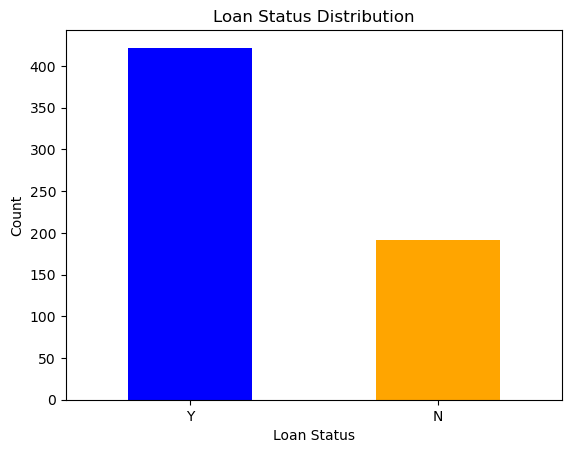

In [22]:
# check the target variable is balanced or imbalanced
import matplotlib.pyplot as plt
loan_status_counts = data['Loan_Status'].value_counts()

loan_status_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



Above graph shows that our target variable is not balanced

In [23]:
# balancing the imbalanced target using SMOTE - Sinthetic Minority OverSampling Technique
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_encoded_data, y_encoded_data)

In [24]:
# splitting the dependent and independent features into train and test split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [25]:
# normalizing all the data points to make features to be similar, so that all features contributes equally to the model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

# initializing all the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# grid search for all algo
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}
# Run classifiers with GridSearchCV
results = {}
best_models = {}  # Dictionary to store best models
for name, clf in classifiers.items():
    print(f"Running {name}...")
    grid_search = GridSearchCV(clf, param_grid=param_grids[name], cv=5)
    grid_search.fit(x_train_scaled, y_train)
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(x_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'best_parameters': grid_search.best_params_,
        'accuracy': accuracy
    }
    print(f"{name} - Best Parameters: {grid_search.best_params_}, Accuracy: {accuracy}")
    
    # Save best model
    best_models[name] = best_clf
    joblib.dump(best_clf, f'best_model_{name}.joblib')

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Accuracy - {result['accuracy']}, Best Parameters - {result['best_parameters']}")


Running Logistic Regression...
Logistic Regression - Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}, Accuracy: 0.8402366863905325
Running KNN...
KNN - Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}, Accuracy: 0.7988165680473372
Running SVM...
SVM - Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}, Accuracy: 0.834319526627219
Running Random Forest...
Random Forest - Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Accuracy: 0.863905325443787
Running Decision Tree...
Decision Tree - Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}, Accuracy: 0.8165680473372781

Results:
Logistic Regression: Accuracy - 0.8402366863905325, Best Parameters - {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
KNN: Accuracy - 0.7988165680473372, Best Parameters - {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
SVM: Accuracy - 0.83431952